<a href="https://colab.research.google.com/github/MScharnberg/IntSys19/blob/master/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook

Intelligent Systems

---

[@mats.scharnberg](mailto:mats.scharnberg@study.hs-duesseldorf.de)

[@christoph.schneider](mailto:christoph.schneider@study.hs-duesseldorf.de)

[@tobias.vossen](mailto:tobias.vossen@study.hs-duesseldorf.de)

## Contents

* Setup
* Data
* Model
* Deployment

## Setup

In [1]:
# Showcase this Notebook?
_SHOWCASE = True #@param ["True", "False"] {type:"raw"}

### Magic

In [2]:
%matplotlib inline
%load_ext tensorboard 

### Libraries

In [3]:
import os
import shutil

In [4]:
import numpy as np
print('NumPy version:', np.__version__)

from matplotlib import pyplot as plt

from tensorboard import version
print('TensorBoard version:', version.VERSION)
from tensorboard.plugins.hparams import api as hp

import tensorflow as tf
print('TensorFlow version:', tf.__version__)
from tensorflow import keras

import tensorflow_datasets as tfds
print('TensorFlow Datasets version:', tfds.__version__)

NumPy version: 1.18.5
TensorBoard version: 2.2.2
TensorFlow version: 2.2.0
TensorFlow Datasets version: 2.1.0


## Data

*   Load dataset
*   Explore dataset
*   Preprocess dataset
*   Visualize dataset


### Constants

In [5]:
_BS = 32 #@param {type:"slider", min:16, max:64, step:16}
_DIM = 28 #@param ["28"] {type:"raw"}
_DS = 'mnist'
_INPUT = 196 # Noise input
_SHAPE = (_DIM, _DIM, 1) # Image shape
_SIZE = '[:100%]' # Dataset size

### Load dataset

In [6]:
def load_dataset(dataset):
  """Load dataset by means of TFDS (TensorFlow Datasets)
  
  Args:
    dataset: String
  
  Returns:
    train: tf.data.Dataset
    test: tf.data.Dataset
  """

  (train, test), info = tfds.load(dataset,
                            split=['train'+_SIZE, 'test'+_SIZE],
                            as_supervised=True,
                            with_info=True)

  print('Description:', info.description)
  print('Source:', info.homepage)
  print('Total number of examples:', info.splits['train'].num_examples + info.splits['test'].num_examples)
  return train, test

In [7]:
train_dataset, test_dataset = load_dataset(_DS)

Description: The MNIST database of handwritten digits.
Source: http://yann.lecun.com/exdb/mnist/
Total number of examples: 70000


### Preprocess dataset

In [8]:
def normalize(image, label):
  """Normalize dataset 
  
  Normalize:
    Cast -> Normalize

  Args:
    image: tf.Tensor as Integer
    label: tf.Tensor as Integer
  
  Returns:
    image: tf.Tensor as Float
    label: tf.Tensor as Float
    noise: tf.Tensor as Float
  """

  image = tf.cast(image, tf.float32)
  image = (image - 127.5) / 127.5 # -1...1
  
  label = tf.cast(label, tf.float32) # (1)
  noise = tf.random.normal((_INPUT, )) # (196)
  # noise = tf.random.normal((_INPUT, ), mean=tf.math.truediv(label, 10.0)) # (196)
  label = tf.expand_dims(label, -1)

  return image, label, noise

In [9]:
def preprocess(dataset, shuffle=True, batch=True, prefetch=True):
  """Preprocess dataset

  Preprocess: 
    Normalize -> Shuffle -> Batch -> Prefetch
  
  Args:
    dataset: tf.data.Dataset
    shuffle: boolean
    batch: boolean
    prefetch: boolean
  
  Returns:
    dataset: tf.data.Dataset
  """

  dataset = dataset.map(normalize)
  if shuffle: dataset = dataset.shuffle(tf.data.experimental.cardinality(dataset))
  if batch: dataset = dataset.batch(_BS, drop_remainder=True)
  if prefetch: dataset = dataset.prefetch(1)
  return dataset

In [10]:
train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)

### Visualize dataset

In [11]:
def visualize(dataset):
  """Visualize dataset
  
  Args:
    dataset: tf.data.Dataset
  """

  dataset = dataset.unbatch()
  fig = plt.figure(figsize=(8, 8))
  i = 0
  for image, label, noise in dataset.take(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.title(int(label.numpy()))
    plt.axis('off')
    i = i+1

  plt.suptitle('Real data instances')
  plt.show()

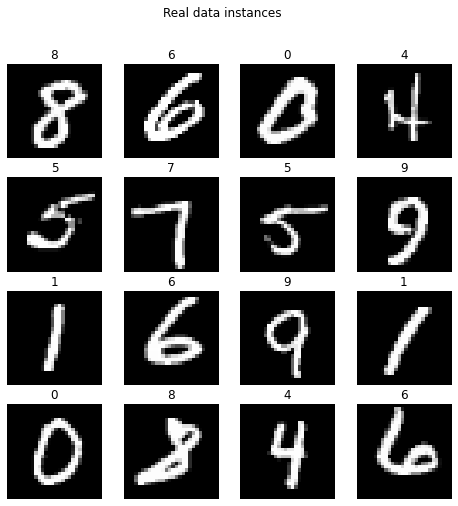

In [12]:
visualize(train_dataset)

## Model

*   Get model
*   Explore model
*   Evaluate model

### Parameters

In [13]:
_INPUT = 196 # Generator input

### Get model

In [14]:
generator_path = keras.utils.get_file('generator.h5', 'https://github.com/MScharnberg/IntSys19/blob/master/model/generator.h5?raw=true', cache_subdir='model')
shutil.move(generator_path, './generator.h5')

458752/458280 [==============================] - 0s 0us/step


'./generator.h5'

In [15]:
discriminator_path = keras.utils.get_file('discriminator.h5', 'https://github.com/MScharnberg/IntSys19/blob/master/model/discriminator.h5?raw=true', cache_subdir='model')
shutil.move(discriminator_path, './discriminator.h5')

483328/478096 [==============================] - 0s 0us/step


'./discriminator.h5'

### Explore model

In [16]:
generator = keras.models.load_model('generator.h5')
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 196)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 8)           288       
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 8)           32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 16)        1152      
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 16)        64

In [17]:
discriminator = keras.models.load_model('discriminator.h5')
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 8)         72        
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        1152      
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 16)      

In [18]:
def explore_model():
  """Explore model
  
  Pipeline: Generator -> Discriminator
    Noise -> Generator -> Image -> Discriminator -> Classification
  """

  # Generator
  noise = tf.random.normal((1, _INPUT))
  image = generator(noise, training=False)

  # Discriminator
  classification = discriminator(image, training=False)
  classification = tf.squeeze(classification, 0) # (1)
  image = tf.squeeze(image) # (28, 28)

  fig = plt.figure(figsize=(8, 4))

  ax1 = fig.add_subplot(1, 2, 1)
  plt.hist(noise, bins=32)
  ax1.title.set_text('Noise')

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(image, cmap='gray')
  ax2.set_axis_off()
  ax2.title.set_text('Output image')

  plt.suptitle('Generator')
  plt.show()

  fig = plt.figure(figsize=(8, 4))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.imshow(image, cmap='gray')
  ax1.set_axis_off()
  ax1.title.set_text('Input image')

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot([classification, classification], [0, 1], 'r-', label='Classification')
  ax2.legend()
  ax2.title.set_text('Output classification')
  ax2.axes.set_xticks([-1, 0, 1])
  ax2.axes.set_xticklabels(['Copy', 'Unsure', 'Original'])

  plt.suptitle('Discriminator')
  plt.show()

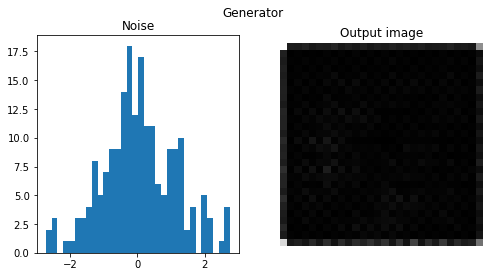

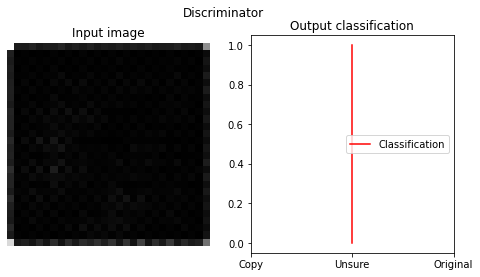

In [19]:
explore_model()

### Evaluate model

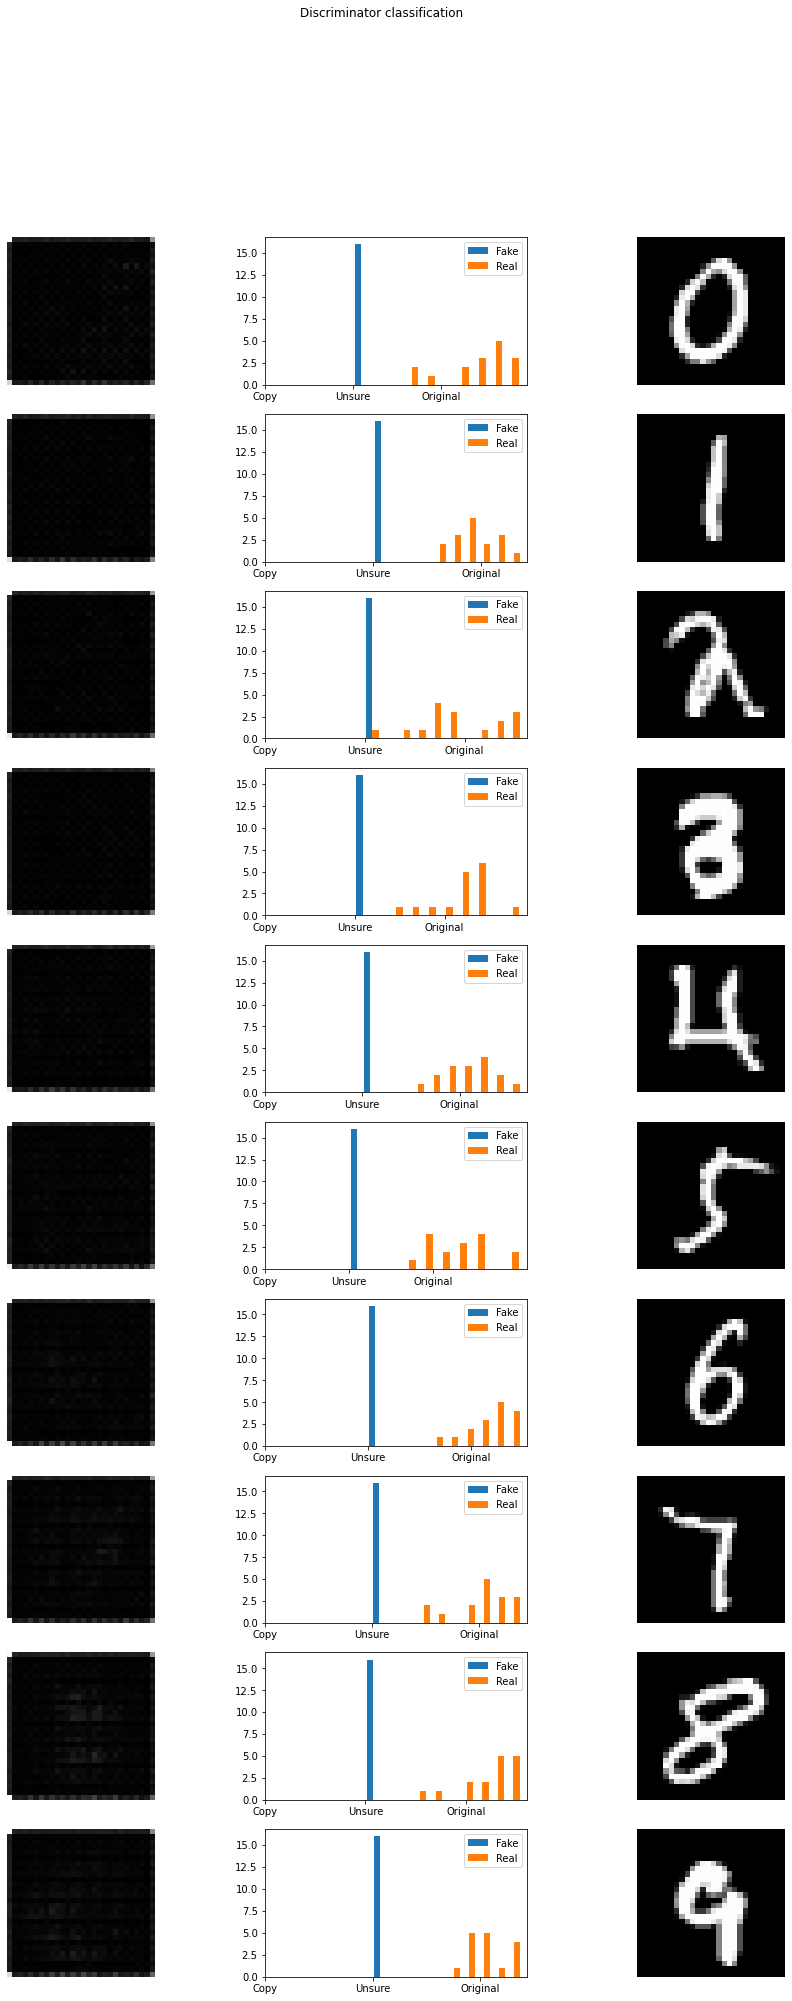

In [20]:
fig = plt.figure(figsize=(16, 32))

for i in range(10):

  # Copy
  noise = tf.random.normal((16, _INPUT, ), mean=tf.math.truediv(float(i), 10.0))
  fake_images = generator(noise, training=False)
  fake_output = discriminator(fake_images, training=False)

  # Original
  real_images = tf.zeros((1, 28, 28, 1), dtype=float)
  for image, label, noise in test_dataset.unbatch().take(-1):
      if label == i:
        real_images = tf.concat([real_images, tf.expand_dims(image, 0)], 0)
        if len(real_images) >= 17: 
          break
          
  real_images = real_images[1:, :, :]
  real_output = discriminator(real_images, training=False)
  
  ax1 = fig.add_subplot(10, 3, 3*i + 1)
  ax1.set_axis_off()
  ax1.imshow(tf.squeeze(fake_images[0]), cmap='gray')

  ax2 = fig.add_subplot(10, 3, 3*i + 2)
  ax2.hist([tf.squeeze(fake_output), tf.squeeze(real_output)])
  ax2.axes.set_xticks([-1, 0, 1])
  ax2.axes.set_xticklabels(['Copy', 'Unsure', 'Original'])
  ax2.legend(['Fake', 'Real'])

  ax3 = fig.add_subplot(10, 3, 3*i + 3)
  ax3.set_axis_off()
  ax3.imshow(tf.squeeze(real_images[0], -1), cmap='gray')

plt.suptitle('Discriminator classification')
plt.show()

## Deployment


*   Use model

### Use model

In [21]:
def generate_multiple():
  """Generate multiple digits

  Args:
    num: Integer
  """

  fig = plt.figure(figsize=(8, 8))

  for i in range(16):
    fig.add_subplot(4, 4, i+1)
    label = np.random.randint(0, high=9)
    input_vector = tf.random.normal((1, _INPUT), mean=tf.realdiv(float(label), 10.0))
    plt.title(int(label))
    image = generator(input_vector, training=True)
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.axis('off')

  plt.suptitle('Fake data instances')
  plt.show()

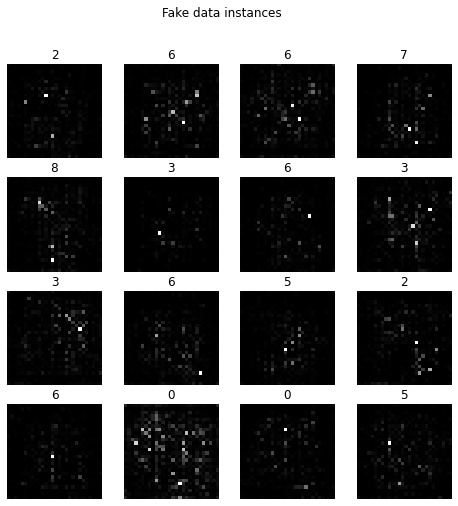

In [22]:
generate_multiple()